In [11]:
import sys
import os
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive

    drive.mount('/gdrive')
    % cd / gdrive / My Drive / ANNDL-H1 /
    !pip install sklearn
    !pip install visualkeras

import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
import keras_cv as keras_cv

#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import *
from ModelHelper import ModelHelper

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')
#Create Instances Of Utils Helper
seed = 5000
labels = {0: 'Species1', 1: 'Species2', 2: 'Species3', 3: 'Species4', 4: 'Species5', 5: 'Species6', 6: 'Species7',
          7: 'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../", seed, create_dirs=True)  #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper = ModelHelper("../../", labels)  #take in input local models folder and lables
model_helper.create_seed(tf, seed);

#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000,
                                                                     featurewise_center=False,
                                                                     samplewise_center=False,
                                                                     featurewise_std_normalization=False,
                                                                     samplewise_std_normalization=False,
                                                                     disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=9634)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)


2.10.0
Data Augmentation with data distribution
Data distribution = [0.1353125 0.1214125 0.1220625 0.1222625 0.1214625 0.1338125 0.1212625
 0.1224125]
Class Size :  149, generating: 2706
2512 images generated
Class Size :  427, generating: 2428
2295 images generated
Class Size :  414, generating: 2441
2422 images generated
Class Size :  410, generating: 2445
2402 images generated
Class Size :  426, generating: 2429
2290 images generated
Class Size :  179, generating: 2676
2487 images generated
Class Size :  430, generating: 2425
2310 images generated
Class Size :  407, generating: 2448
2387 images generated


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 32)        9248  

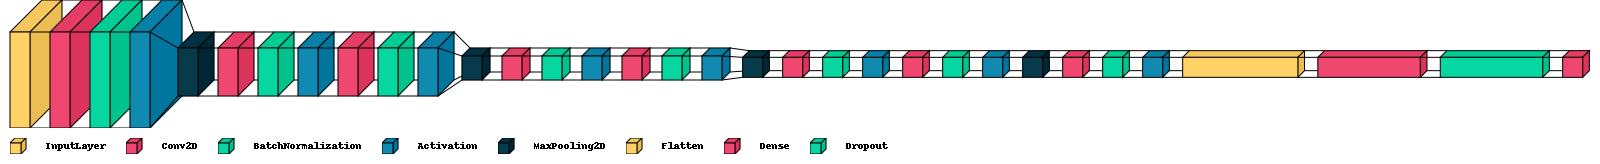

In [12]:
input_shape = X_train.shape[1:]  # 96*96*3
batch_size = 128
epochs = 50


def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    depth = 8
    start_n_f = 32
    last_layer = input_layer

    # last_layer = keras_cv.layers.GridMask(
    #     ratio_factor=(0, 0.5),
    #     rotation_factor=0.15,
    #     fill_mode="constant",
    #     fill_value=0.0,
    # )(last_layer)

    for i in range(depth):
        kernel_size = (3, 3) if i == 0 else (3, 3)
        conv = tfkl.Conv2D(
            filters=start_n_f,
            kernel_size=kernel_size,
            strides=(1, 1),
            padding='same',
            activation=None,
            kernel_initializer=tfk.initializers.HeUniform(seed)
        )(last_layer)
        batch = BatchNormalization()(conv)
        activation = tfkl.Activation('relu')(batch)
        last_layer = activation
        if i % 2 == 0:
            pool = tfkl.MaxPooling2D((2, 2), padding='same')(activation)
            last_layer = pool
            start_n_f *= (1 if i % 2 == 0 else 2)

    flattening_layer = tfkl.Flatten(name='Flatten')(last_layer)
    classifier_layer = tfkl.Dense(
        units=1024,
        name='Classifier',
        activation='relu',
        kernel_initializer=tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer=tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

Epoch 1/100


2022-11-22 08:53:28.497944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - ETA: 0s - loss: 1.5644 - accuracy: 0.4091WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_test_function.<locals>.test_function at 0x3e8ebdf70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2022-11-22 08:53:46.925691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - 19s 73ms/step - loss: 1.5644 - accuracy: 0.4091 - val_loss: 1.9494 - val_accuracy: 0.3785
Epoch 2/100
252/252 [==============================] - 16s 64ms/step - loss: 1.1734 - accuracy: 0.5563 - val_loss: 1.5839 - val_accuracy: 0.4492
Epoch 3/100
252/252 [==============================] - 17s 66ms/step - loss: 0.9899 - accuracy: 0.6291 - val_loss: 1.9396 - val_accuracy: 0.4463
Epoch 4/100
252/252 [==============================] - 16s 65ms/step - loss: 0.8665 - accuracy: 0.6760 - val_loss: 1.2660 - val_accuracy: 0.5537
Epoch 5/100
252/252 [==============================] - 16s 64ms/step - loss: 0.7723 - accuracy: 0.7137 - val_loss: 1.4299 - val_accuracy: 0.6102
Epoch 6/100
252/252 [==============================] - 17s 66ms/step - loss: 0.6698 - accuracy: 0.7492 - val_loss: 1.1582 - val_accuracy: 0.6045
Epoch 7/100
252/252 [==============================] - 16s 64ms/step - loss: 0.6049 - accuracy: 0.7787 - val_loss: 1.3682 - val_accuracy: 0.52

INFO:tensorflow:Assets written to: ../../local_saved_models/model_1/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_1/assets


 7/12 [================>.............] - ETA: 0s

2022-11-22 09:11:39.788656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 15ms/step
Accuracy: 0.774
Precision: 0.7483
Recall: 0.7507
F1: 0.7448


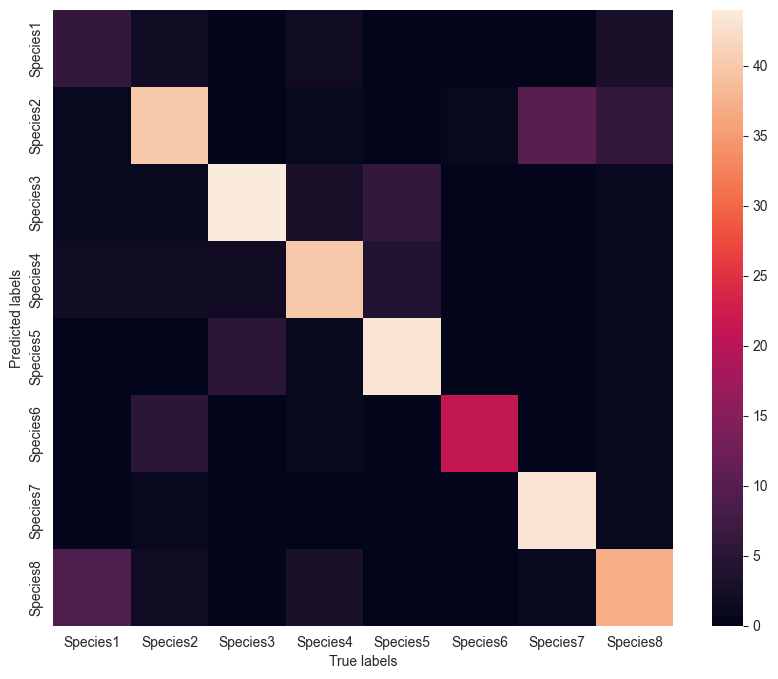

In [13]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_1')
model = model_helper.load_model('model_1')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

Data Augmentation with data distribution
Data distribution = [0.1353125 0.1214125 0.1220625 0.1222625 0.1214625 0.1338125 0.1212625
 0.1224125]
Class Size :  149, generating: 2706
2512 images generated
Class Size :  427, generating: 2428
2295 images generated
Class Size :  414, generating: 2441
2422 images generated
Class Size :  410, generating: 2445
2402 images generated
Class Size :  426, generating: 2429
2290 images generated
Class Size :  179, generating: 2676
2487 images generated
Class Size :  430, generating: 2425
2310 images generated
Class Size :  407, generating: 2448
2387 images generated
Epoch 1/100


2022-11-22 09:12:47.975771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - ETA: 0s - loss: 0.6076 - accuracy: 0.8055

2022-11-22 09:13:04.589634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - 18s 66ms/step - loss: 0.6076 - accuracy: 0.8055 - val_loss: 0.9602 - val_accuracy: 0.7260
Epoch 2/100
252/252 [==============================] - 16s 63ms/step - loss: 0.3835 - accuracy: 0.8668 - val_loss: 1.0405 - val_accuracy: 0.7345
Epoch 3/100
252/252 [==============================] - 16s 63ms/step - loss: 0.3019 - accuracy: 0.8924 - val_loss: 1.0515 - val_accuracy: 0.7401
Epoch 4/100
252/252 [==============================] - 16s 64ms/step - loss: 0.2884 - accuracy: 0.8999 - val_loss: 0.9171 - val_accuracy: 0.7627
Epoch 5/100
252/252 [==============================] - 16s 63ms/step - loss: 0.2159 - accuracy: 0.9228 - val_loss: 1.0558 - val_accuracy: 0.7458
Epoch 6/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1814 - accuracy: 0.9371 - val_loss: 1.0781 - val_accuracy: 0.7514
Epoch 7/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1458 - accuracy: 0.9483 - val_loss: 1.1326 - val_accuracy: 0.74

INFO:tensorflow:Assets written to: ../../local_saved_models/model_2/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_2/assets


 7/12 [================>.............] - ETA: 0s

2022-11-22 09:33:11.944764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 12ms/step
Accuracy: 0.8136
Precision: 0.7877
Recall: 0.7938
F1: 0.7883


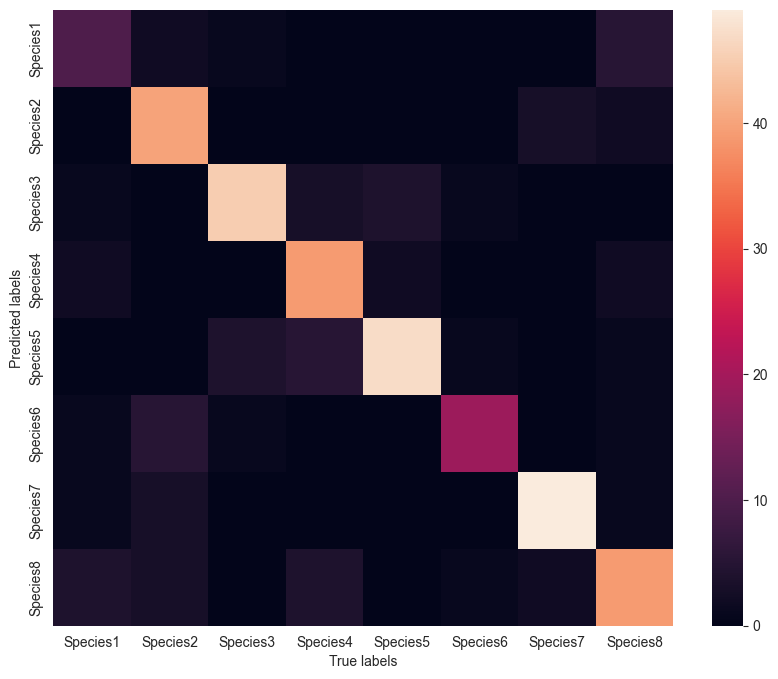

In [14]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=453)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)

# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_2')
model = model_helper.load_model('model_2')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

Data Augmentation with data distribution
Data distribution = [0.1353125 0.1214125 0.1220625 0.1222625 0.1214625 0.1338125 0.1212625
 0.1224125]
Class Size :  149, generating: 2706
2512 images generated
Class Size :  427, generating: 2428
2295 images generated
Class Size :  414, generating: 2441
2422 images generated
Class Size :  410, generating: 2445
2402 images generated
Class Size :  426, generating: 2429
2290 images generated
Class Size :  179, generating: 2676
2487 images generated
Class Size :  430, generating: 2425
2310 images generated
Class Size :  407, generating: 2448
2387 images generated
Epoch 1/100


2022-11-22 09:34:10.343943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.8396

2022-11-22 09:34:26.892294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


252/252 [==============================] - 18s 66ms/step - loss: 0.5281 - accuracy: 0.8396 - val_loss: 0.8606 - val_accuracy: 0.7740
Epoch 2/100
252/252 [==============================] - 16s 63ms/step - loss: 0.3147 - accuracy: 0.8901 - val_loss: 0.8894 - val_accuracy: 0.7599
Epoch 3/100
252/252 [==============================] - 16s 63ms/step - loss: 0.2505 - accuracy: 0.9136 - val_loss: 0.7610 - val_accuracy: 0.8249
Epoch 4/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1936 - accuracy: 0.9325 - val_loss: 0.8460 - val_accuracy: 0.8051
Epoch 5/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1849 - accuracy: 0.9355 - val_loss: 0.9657 - val_accuracy: 0.8136
Epoch 6/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1549 - accuracy: 0.9467 - val_loss: 0.9349 - val_accuracy: 0.7938
Epoch 7/100
252/252 [==============================] - 16s 63ms/step - loss: 0.1350 - accuracy: 0.9532 - val_loss: 1.1208 - val_accuracy: 0.75

INFO:tensorflow:Assets written to: ../../local_saved_models/model_3/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_3/assets


 7/12 [================>.............] - ETA: 0s

2022-11-22 09:47:48.574969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 13ms/step
Accuracy: 0.8107
Precision: 0.7901
Recall: 0.7838
F1: 0.7857


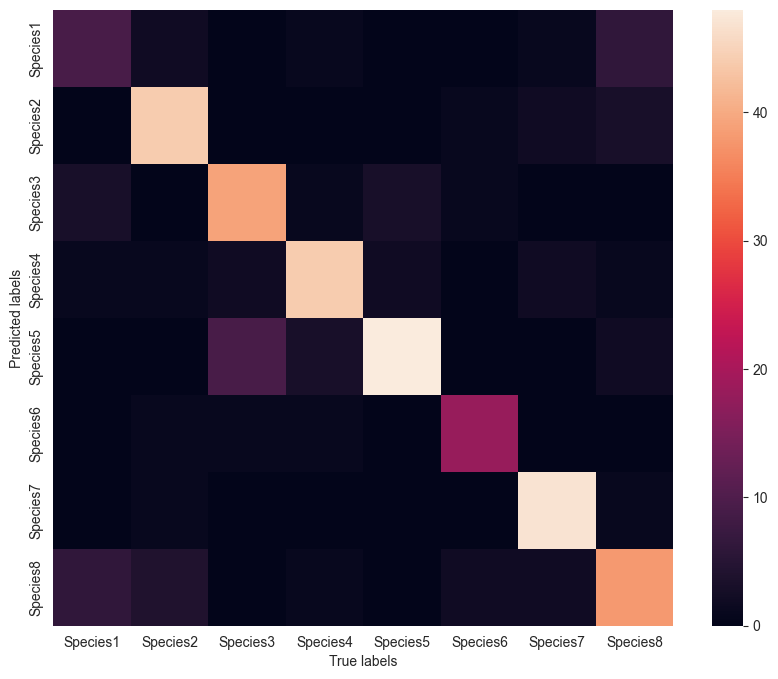

In [15]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 20000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=123)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.1)

# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_3')
model = model_helper.load_model('model_3')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)

Data Augmentation with data distribution
Data distribution = [0.13875    0.12021667 0.12108333 0.12135    0.12028333 0.13675
 0.12001667 0.12155   ]
Class Size :  149, generating: 2081
1937 images generated
Class Size :  427, generating: 1803
1708 images generated
Class Size :  414, generating: 1816
1784 images generated
Class Size :  410, generating: 1820
1768 images generated
Class Size :  426, generating: 1804
1704 images generated
Class Size :  179, generating: 2051
1918 images generated
Class Size :  430, generating: 1800
1720 images generated
Class Size :  407, generating: 1823
1756 images generated
Epoch 1/100


2022-11-22 18:15:17.412856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9835

2022-11-22 18:15:36.960707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


235/235 [==============================] - 22s 79ms/step - loss: 0.0549 - accuracy: 0.9835 - val_loss: 1.3761 - val_accuracy: 0.7938
Epoch 2/100
235/235 [==============================] - 16s 67ms/step - loss: 0.0305 - accuracy: 0.9897 - val_loss: 1.4104 - val_accuracy: 0.8164
Epoch 3/100
235/235 [==============================] - 16s 67ms/step - loss: 0.0437 - accuracy: 0.9868 - val_loss: 1.6257 - val_accuracy: 0.7881
Epoch 4/100
235/235 [==============================] - 16s 67ms/step - loss: 0.0298 - accuracy: 0.9901 - val_loss: 1.8456 - val_accuracy: 0.7486
Epoch 5/100
235/235 [==============================] - 16s 68ms/step - loss: 0.0294 - accuracy: 0.9908 - val_loss: 1.7397 - val_accuracy: 0.7768
Epoch 6/100
235/235 [==============================] - 16s 67ms/step - loss: 0.0283 - accuracy: 0.9913 - val_loss: 1.5134 - val_accuracy: 0.7881
Epoch 7/100
235/235 [==============================] - 16s 67ms/step - loss: 0.0317 - accuracy: 0.9893 - val_loss: 1.4979 - val_accuracy: 0.80

INFO:tensorflow:Assets written to: ../../local_saved_models/model_4/assets


INFO:tensorflow:Assets written to: ../../local_saved_models/model_4/assets


 5/12 [===========>..................] - ETA: 0s

2022-11-22 18:26:18.388591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 16ms/step
Accuracy: 0.8559
Precision: 0.8353
Recall: 0.841
F1: 0.8364


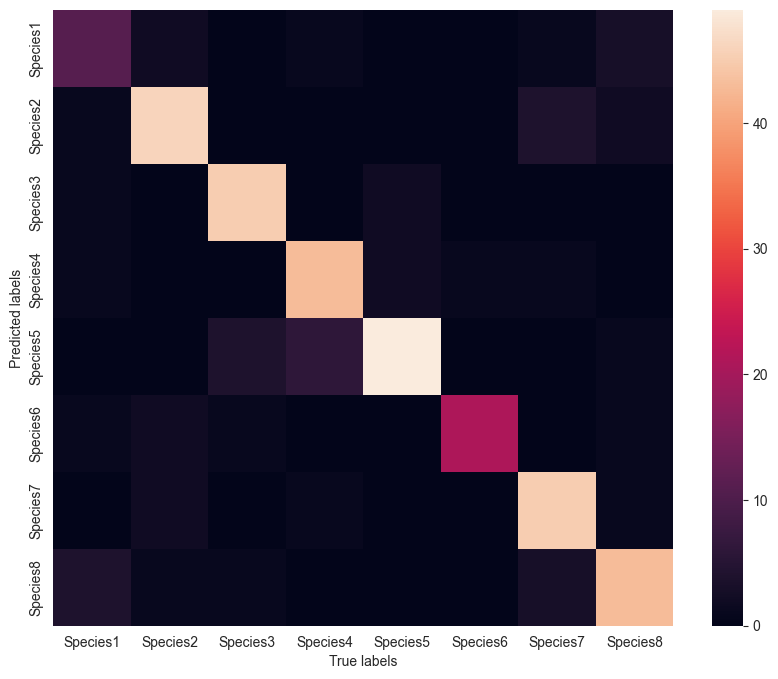

In [20]:
#Load Dataset
X, Y = dataset_helper.load_dataset_from_numpy()
dataset_size = X.shape[0]
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),
                                                    stratify=Y)

# Normalize data
X_train = X_train / 255.
X_test = X_test / 255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed,
                                                  test_size=int(0.1 * dataset_size), stratify=Y_train)
old_y_train = Y_train
X_train, Y_train = dataset_helper.apply_data_augmentation_normalized(X_train, Y_train, 15000, disable_tqdm=True,
                                                                     rotation_range=360,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2,
                                                                     zoom_range=0.3,
                                                                     fill_mode="reflect",
                                                                     horizontal_flip=True,
                                                                     vertical_flip=True,
                                                                     brightness_range=(0.5, 1.1), seed=8374)

X_train, Y_train = DatasetHelper.keras_cv_augmentation(X_train, Y_train, 0.15)
import random

c = list(zip(X_train, Y_train))
random.shuffle(c)
X_train, Y_train = zip(*c)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
callbacks_selected = model_helper.createCallbacks(earlyStopping=True, checkPoints=True, patience=25)

#Fit the model
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_val, Y_val),
    callbacks=callbacks_selected
).history

model_helper.save_model(model, 'model_4')
model = model_helper.load_model('model_4')
model_helper.show_confusion_matrix(X_test, Y_test, model=model)